# Homework 5

### Jingheng Huan
Netid: jh730

## Here is how to load and display the Chinese equivalent to MNIST

Data has been collected by K. Nazarpour and M. Chen at Newcastle university:
https://data.ncl.ac.uk/articles/dataset/Handwritten_Chinese_Numbers/10280831/1
Preprocessing was done by Gabriel Preda:
https://www.kaggle.com/data/174582

In [1]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
%matplotlib inline 

# if you have problems with the visualization of the Chinese characters use mplfont
# from https://github.com/Clarmy/mplfonts
# pip install mplfonts
# mplfonts init


# if you have problems with displaying minus signs in the exponents of numbers, uncomment the next two lines
from mplfonts import use_font
use_font('Noto Serif CJK SC')

In [2]:
# loading images and labels 
with open('X.npy', 'rb') as np_file:
    X = np.load(np_file)

with open('y.npy', 'rb') as np_file:
    y = np.load(np_file)    

# loading dictionaries to display numerical values and characters    
import json
with open('value_dict.json','r') as json_file:
    value_dict = json.load(json_file)
    
with open('char_dict.json','r') as json_file:
    char_dict = json.load(json_file)    
    
number_char = len(char_dict)
print('number of classes:', number_char)    

number of classes: 15


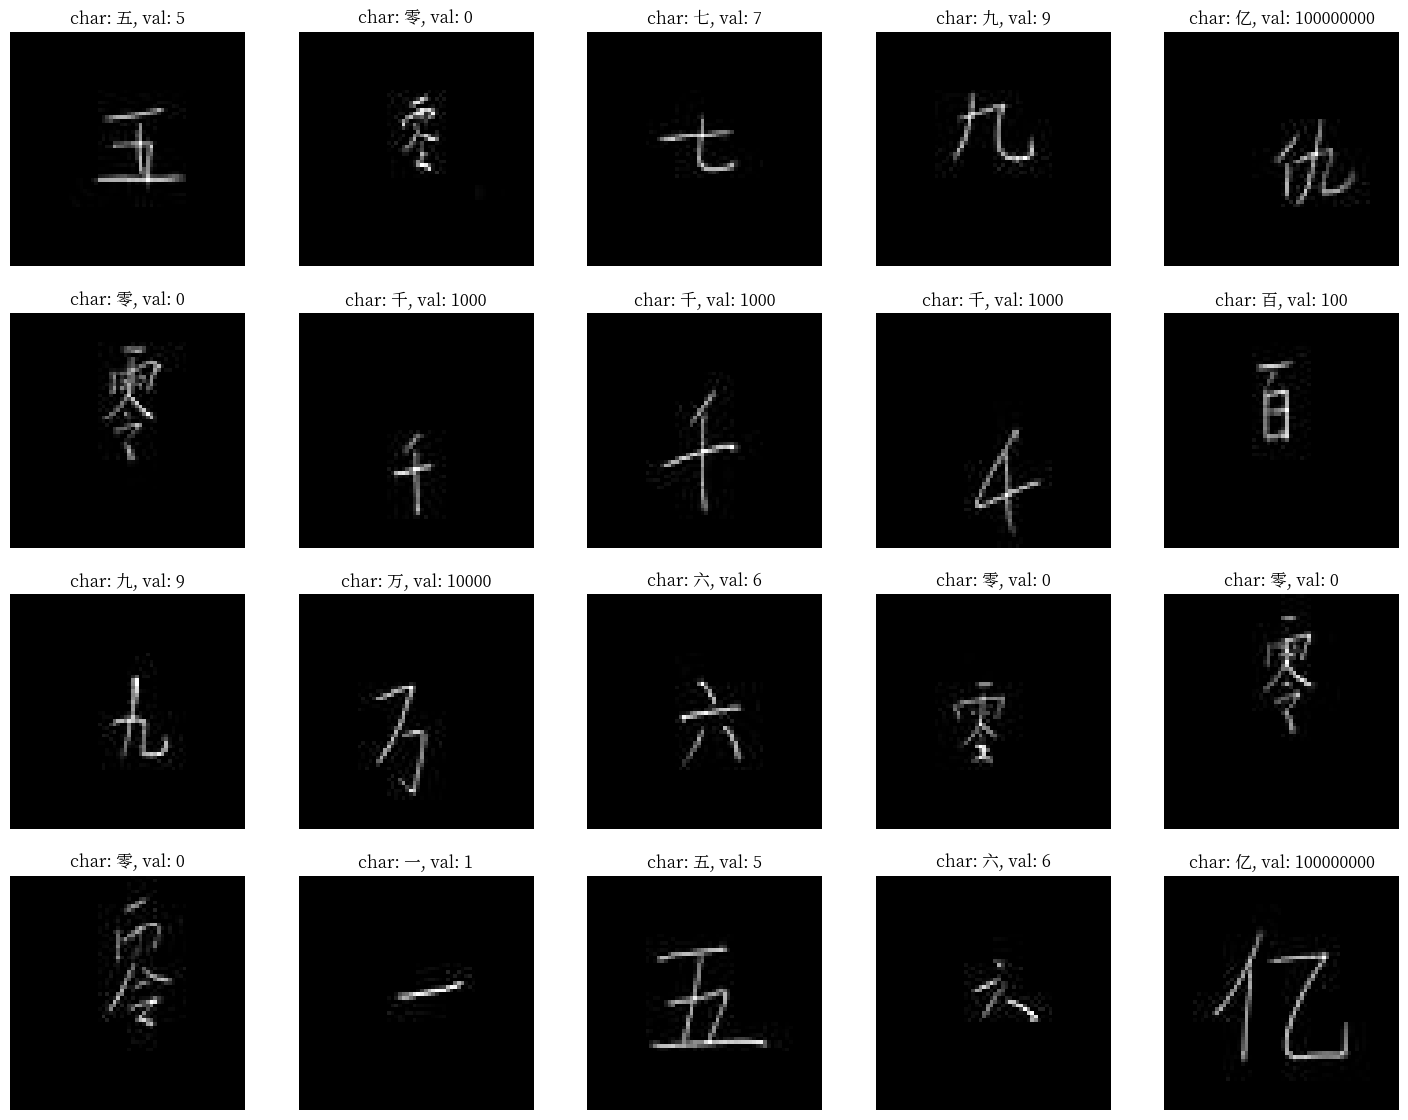

In [3]:
# preview the images
plt.figure(figsize=(18,14))

for i in range(20):  
    plt.subplot(4, 5, i+1)
    plt.imshow(X[i].reshape((64,64)),cmap='gray')
    key = str(y[i])
    plt.title('char: {}, val: {}'.format(char_dict[key],value_dict[key]))
    plt.axis('off')
plt.show()

In [4]:
# this array can be used for labeling the confusion matrix using seaborn
axis_labels = [char_dict['0'], char_dict['1'], char_dict['2'], char_dict['3'], char_dict['4'],
               char_dict['5'], char_dict['6'], char_dict['7'], char_dict['8'], char_dict['9'],
               char_dict['10'], char_dict['11'], char_dict['12'], char_dict['13'], char_dict['14'],
              ]
# you might also want to use: plt.yticks(rotation=0) 

## 1) Chinese MNIST, using a CNN
**(3 points)**

Aim of this exercise is to train a CNN classifier for the 15 different Chinese characters for numbers. 

First prepare the data: turn *X* into a float in the range 0 to 1, and convert *y* to a one-hot vector. Then do an 0.7/0.3 train/test split.

Then built a CNN with 2 convolutional layers (each 3x3 filter size and relu activation, the first with 32, the second with 64 filters). After each convolution layer there should be a max pooling 2x2 layer.  After the second max pooling, built a sequence of a 25% droput, flatten, dense layer (128 neurons, relu), 50% dropout, and finally a softmax output layer. 

Train the CNN with categorical_crossentropy as loss function, Adam as optimizer, accuracy as metrics for 20 epochs with a batch size of 128.

Display your result by a) computing the accuracy on the test set, b) making two graphs how loss and accuracy change with epoch, and c) computing the confusion matrix.

**ANSWER**

In [5]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

X = X.reshape(-1, 64, 64, 1)
X = X.astype('float32') / 255.0

y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(X_train.shape[1:])),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


## 2) Learning an image as a function

**(5 points)**

The Universal approximation theorem asserts that even a neural networks with only one hidden layer can approximate any (mathematically well behaved) function. Now let's consider the function that describes one of our images. It depends on two variables: the coordinates of a given pixel. Therefore the function is only defined for 0<x<image_height, respectively 0<y<image_width. The output value of that function is a vector with three numbers, the R, G, and B value of that pixel.
Observe, that there is no test train split: all pixel coordinates will be used for training. 

In part a) of this exercise you will train a small neural network to learn a function describing an image. In part b) you will learn an interesting trick to improve that training. 

**a)** The first two cells already provide the feature values: *X* is an array containing all possible pixel coordinates (already normalized to go from 0 to 1). You have to then to create in cell 5 the appropriate target vector *y*  from the image matrix 'astro' which we load in cell three. If you succeeded then the two images in cell 6 will be identical.

Then built a neural network with 4 layers of 256 neurons (relu activation) each, followed by an output layer with sigmoid activation. Use *all* data to train that network using the following parameters: 
loss: mean squared error, optimizer: Adam, learning rate: 0.005, batch size 2000, number of epochs: 500. Also save the training history for part b.

Then make a prediction using *X* and display the learned image. Finally compute the Peak Signal-to-Noise Ratio (PSNR) using the original and the predicted image. PSNR is a concept that will be introduced in one of Tuesday's presentations.
(*2.5 points*) 

**b)** First we expand our feature vector *X* by adding 4 new columns. To create those, first rescale columns one and two so that they cover the range 0 to 2 pi. Columns three and four containe the sine and cosine of the rescaled first column, columns five and six containe the sine and cosine of the rescaled second column.  Observe that this expansion is completely generic; it has nothing to do with the image we try to learn.

Built another neural network identical to the first one, except for the changes you need to accomodate for the new *X*, then train the same way as in part a). Make a new prediction and display it (you should see a noticable improvement, though still not perfect result). Again, compute the PSNR. Finally, plot the two loss curves as a function of epoch number.  (*2.5 point*)   

**ANSWER**

In [6]:
# the features of our training data are the coordinates of a 256 by 256 square image
size = 256
X_int = np.stack([x for x in np.ndindex(size,size)])

# now we rescale our features to be between 0 and 1
X = X_int/255
print('X has {} rows (number of pixels) and {} columns (the x and y coordinate of those pixels)'.format(X_int.shape[0], X_int.shape[1]))

X has 65536 rows (number of pixels) and 2 columns (the x and y coordinate of those pixels)


In [7]:
print('the image rows increase slow, the image columns fast:\n',X)

the image rows increase slow, the image columns fast:
 [[0.         0.        ]
 [0.         0.00392157]
 [0.         0.00784314]
 ...
 [1.         0.99215686]
 [1.         0.99607843]
 [1.         1.        ]]


In [8]:
# creating our target function
from skimage import img_as_float
from skimage.io import imread
astro = imread('astronaut.png')
# we crop the top left corner to the right size
astro=astro[0:size, 0:size,:]

# convert the RGB channels to floats with range 0 to 1
astro = img_as_float(astro)
print(astro.min(), astro.max())

OSError: No such file: 'astronaut.png'. This file looks like one of the standard images, but from imageio 2.1, standard images have to be specified using "imageio:astronaut.png".

In [ ]:
# the target vector has the same length than the feature vector, 
# but contains 3 columns for the R,G, and B value of our image
y = np.zeros((X_int.shape[0],3))

In [ ]:
# your code here, writing the RGB values into the target vector y


In [ ]:
# the two images need to be identical
plt.figure(figsize=(14,6))

plt.subplot(121)
plt.imshow(astro)
plt.axis('off')
plt.title('the original image', fontsize=16)

plt.subplot(122)
plt.imshow(y.reshape(size,size,3))  # reshape is important to make it an image again
plt.axis('off')
plt.title('the target function we want the network to learn', fontsize=16)
plt.show()